![](https://images.unsplash.com/photo-1602084551218-a28205125639?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2070&q=80)

<div class = 'alert alert-block alert-info'
     style = 'background-color:#4c1c84;
              color:#eeebf1;
              border-width:5px;
              border-color:#4c1c84;
              font-family:Comic Sans MS;
              border-radius: 50px 50px'>
    <p style = 'font-size:24px'>Exp 033</p>
    <a href = "#Config"
       style = "color:#eeebf1;
                font-size:14px">1.Config</a><br>
    <a href = "#Settings"
       style = "color:#eeebf1;
                font-size:14px">2.Settings</a><br>
    <a href = "#Data-Load"
       style = "color:#eeebf1;
                font-size:14px">3.Data Load</a><br>
    <a href = "#Pytorch-Settings"
       style = "color:#eeebf1;
                font-size:14px">4.Pytorch Settings</a><br>
    <a href = "#Training"
       style = "color:#eeebf1;
                font-size:14px">5.Training</a><br>
</div>

<p style = 'font-size:24px;
            color:#4c1c84'>
    実施したこと
</p>
    <li style = "color:#4c1c84;
                font-size:14px">使用データ:Jigsaw-Classification</li>
    <li style = "color:#4c1c84;
                font-size:14px">使用モデル:unitary/toxic-bert</li>
    <li style = "color:#4c1c84;
                font-size:14px">Attentionの可視化</li>

<br>
<h1 style = "font-size:45px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    Config
</h1>
<br>

In [1]:
import sys
sys.path.append("../src/utils/iterative-stratification/")
sys.path.append("../src/utils/detoxify")
sys.path.append("../src/utils/coral-pytorch/")
sys.path.append("../src/utils/pyspellchecker")

In [2]:
import warnings
warnings.simplefilter('ignore')

import os
import gc
gc.enable()
import sys
import glob
import copy
import math
import time
import random
import string
import psutil
import pathlib
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict
from box import Box
from typing import Optional
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

from tqdm.auto import tqdm as tqdmp
from tqdm.autonotebook import tqdm as tqdm
tqdmp.pandas()

## Model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AdamW, AutoModelForSequenceClassification
from transformers import RobertaModel, RobertaForSequenceClassification
from transformers import RobertaTokenizer
from transformers import LukeTokenizer, LukeModel, LukeConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from transformers import BertTokenizer, BertForSequenceClassification, BertForMaskedLM
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from transformers import DebertaTokenizer, DebertaModel

# Pytorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning import callbacks
from pytorch_lightning.callbacks.progress import ProgressBarBase
from pytorch_lightning import LightningDataModule, LightningDataModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.loggers.csv_logs import CSVLogger
from pytorch_lightning.callbacks import RichProgressBar

from sklearn.linear_model import Ridge
from sklearn.svm import SVC, SVR
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import rankdata
from cuml.svm import SVR as cuml_SVR
from cuml.linear_model import Ridge as cuml_Ridge
import cudf
from detoxify import Detoxify
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from ast import literal_eval
from nltk.tokenize import TweetTokenizer
import spacy
from scipy.stats import sem
from copy import deepcopy
from spellchecker import SpellChecker
from typing import Text, Set, List


2022-01-28 02:22:52.130585: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [3]:
import torch

config = {
    "exp_comment":"Jigsaw-Classification をHateBERTで学習",
    "seed": 42,
    "root": "/content/drive/MyDrive/kaggle/Jigsaw/raw",
    "n_fold": 5,
    "epoch": 5,
    "max_length": 256,
    "environment": "AWS",
    "project": "Jigsaw",
    "entity": "dataskywalker",
    "exp_name": "032_exp",
    "margin": 0.5,
    "train_fold": [0, 1, 2, 3, 4],

    "trainer": {
        "gpus": 1,
        "accumulate_grad_batches": 8,
        "progress_bar_refresh_rate": 1,
        "fast_dev_run": True,
        "num_sanity_val_steps": 0,
    },

    "train_loader": {
        "batch_size": 8,
        "shuffle": True,
        "num_workers": 1,
        "pin_memory": True,
        "drop_last": True,
    },

    "valid_loader": {
        "batch_size": 8,
        "shuffle": False,
        "num_workers": 1,
        "pin_memory": True,
        "drop_last": False,
    },

    "test_loader": {
        "batch_size": 8,
        "shuffle": False,
        "num_workers": 1,
        "pin_memory": True,
        "drop_last": False,
    },

    "backbone": {
        "name": "GroNLP/hateBERT",
        "output_dim": 1,
    },

    "optimizer": {
        "name": "torch.optim.AdamW",
        "params": {
            "lr": 1e-6,
        },
    },

    "scheduler": {
        "name": "torch.optim.lr_scheduler.CosineAnnealingWarmRestarts",
        "params": {
            "T_0": 20,
            "eta_min": 0,
        },
    },

    "loss": "nn.MSELoss",
}

config = Box(config)
config.tokenizer = AutoTokenizer.from_pretrained(config.backbone.name)
config.model = BertForMaskedLM.from_pretrained(config.backbone.name)
# pprint(config)

In [4]:
config.tokenizer.save_pretrained(f"../data/processed/{config.backbone.name}")

pretrain_model = BertForMaskedLM.from_pretrained(config.backbone.name)
pretrain_model.save_pretrained(f"../data/processed/{config.backbone.name}")

In [5]:
# 個人的にAWSやKaggle環境やGoogle Colabを行ったり来たりしているのでまとめています
import os
import sys
from pathlib import Path

if config.environment == 'AWS':
    
    INPUT_DIR = Path('/mnt/work/data/kaggle/Jigsaw/')
    MODEL_DIR = Path(f'../models/{config.exp_name}/')
    OUTPUT_DIR = Path(f'../data/interim/{config.exp_name}/')
    UTIL_DIR = Path('/mnt/work/shimizu/kaggle/PetFinder/src/utils')
    
    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    print(f"Your environment is 'AWS'.\nINPUT_DIR is {INPUT_DIR}\nMODEL_DIR is {MODEL_DIR}\nOUTPUT_DIR is {OUTPUT_DIR}\nUTIL_DIR is {UTIL_DIR}")
    
    
elif config.environment == 'Kaggle':
    INPUT_DIR = Path('../input/*****')
    MODEL_DIR = Path('./')
    OUTPUT_DIR = Path('./')
    print(f"Your environment is 'Kaggle'.\nINPUT_DIR is {INPUT_DIR}\nMODEL_DIR is {MODEL_DIR}\nOUTPUT_DIR is {OUTPUT_DIR}")

    
elif config.environment == 'Colab':
    INPUT_DIR = Path('/content/drive/MyDrive/kaggle/Jigsaw/raw')
    BASE_DIR = Path("/content/drive/MyDrive/kaggle/Jigsaw/interim")

    MODEL_DIR = BASE_DIR / f'{config.exp_name}'
    OUTPUT_DIR = BASE_DIR / f'{config.exp_name}/'

    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    if not os.path.exists(INPUT_DIR):
        print('Please Mount your Google Drive.')
    else:
        print(f"Your environment is 'Colab'.\nINPUT_DIR is {INPUT_DIR}\nMODEL_DIR is {MODEL_DIR}\nOUTPUT_DIR is {OUTPUT_DIR}")
        
else:
    print("Please choose 'AWS' or 'Kaggle' or 'Colab'.\nINPUT_DIR is not found.")

Your environment is 'AWS'.
INPUT_DIR is /mnt/work/data/kaggle/Jigsaw
MODEL_DIR is ../models/032_exp
OUTPUT_DIR is ../data/interim/032_exp
UTIL_DIR is /mnt/work/shimizu/kaggle/PetFinder/src/utils


In [6]:
# Seed固定
seed_everything(config.seed)

42

In [7]:
## 処理時間計測
@contextmanager
def timer(name:str, slack:bool=False):
    t0 = time.time()
    p = psutil.Process(os.getpid())
    m0 = p.memory_info()[0] / 2. ** 30
    print(f'<< {name} >> Start')
    yield
    
    m1 = p.memory_info()[0] / 2. ** 30
    delta = m1 - m0
    sign = '+' if delta >= 0 else '-'
    delta = math.fabs(delta)
    
    print(f"<< {name} >> {m1:.1f}GB({sign}{delta:.1f}GB):{time.time() - t0:.1f}sec", file=sys.stderr)

<br>
<h1 style = "font-size:45px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    Data Load
</h1>
<br>

In [8]:
## Data Check
for dirnames, _, filenames in os.walk(INPUT_DIR):
    
    for filename in filenames:

        print(f'{dirnames}/{filename}')

/mnt/work/data/kaggle/Jigsaw/comments_to_score.csv
/mnt/work/data/kaggle/Jigsaw/sample_submission.csv
/mnt/work/data/kaggle/Jigsaw/validation_data.csv


In [9]:
val_df = pd.read_csv("/mnt/work/data/kaggle/Jigsaw/validation_data.csv")
test_df = pd.read_csv("/mnt/work/data/kaggle/Jigsaw/comments_to_score.csv")

display(val_df.head())
display(test_df.head())

,worker,less_toxic,more_toxic
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu..."
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist"


,comment_id,text
0,114890,"""\n \n\nGjalexei, you asked about whether ther..."
1,732895,"Looks like be have an abuser , can you please ..."
2,1139051,I confess to having complete (and apparently b...
3,1434512,"""\n\nFreud's ideas are certainly much discusse..."
4,2084821,It is not just you. This is a laundry list of ...


<br>
<h2 style = "font-size:45px;
             font-family:Comic Sans MS ;
             font-weight : normal; 
             background-color: #eeebf1 ;
             color : #4c1c84;
             text-align: center;
             border-radius: 100px 100px;">
    Jigsaw Classification
</h2>
<br>

In [10]:
train_df = pd.read_csv("../data/external/jigsaw-classification/train.csv.zip")
display(train_df.head(10))
display(train_df.shape)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


(159571, 8)

In [11]:
train_df["is_colon"] = train_df["comment_text"].progress_apply(lambda x:1 if ":" in x else 0)

  0%|          | 0/159571 [00:00<?, ?it/s]

In [12]:
def preprocess_text(txt:str) -> str:
    
    new_texts = txt
    new_texts = new_texts.replace(":", ",")
    
    return new_texts

In [13]:
train_df["text"] = train_df["comment_text"].progress_apply(preprocess_text)
test_df["text"] = test_df["text"].progress_apply(preprocess_text)
val_df["less_toxic"] = val_df["less_toxic"].progress_apply(preprocess_text)
val_df["more_toxic"] = val_df["more_toxic"].progress_apply(preprocess_text)

  0%|          | 0/159571 [00:00<?, ?it/s]

  0%|          | 0/7537 [00:00<?, ?it/s]

  0%|          | 0/30108 [00:00<?, ?it/s]

  0%|          | 0/30108 [00:00<?, ?it/s]

In [17]:
import re

spell = SpellChecker(distance=1)

def misspelt_words_fn(dataframe: pd.DataFrame, col="text") -> Set[Text]:
    misspelt_words = set()
    for tweet in dataframe[col].str.casefold():
        [misspelt_words.add(word) for word in spell.unknown(tweet.split())]
    return misspelt_words


WORD = re.compile(r'\w+')
def reTokenize(tweet: Text) -> List[Text]:
    return WORD.findall(tweet.casefold())

PATTERN = re.compile(r"(.)\1{2,}")
def reduce_lengthening(text: Text) -> Text:
    return PATTERN.sub(r"\1\1", text)

def spell_correction(text: Text) -> Text:
    return ' '.join([spell.correction(word)
                     if word in misspelt_words else word
                     for word in reTokenize(reduce_lengthening(text))])


In [18]:
misspelt_words = misspelt_words_fn(train_df, "text")
train_df["text"] = train_df["text"].progress_apply(spell_correction)

misspelt_words = misspelt_words_fn(test_df, "text")
test_df["text"] = test_df["text"].progress_apply(spell_correction)

misspelt_words = misspelt_words_fn(val_df, "less_toxic")
val_df["less_toxic"] = val_df["less_toxic"].progress_apply(spell_correction)

misspelt_words = misspelt_words_fn(val_df, "more_toxic")
val_df["more_toxic"] = val_df["more_toxic"].progress_apply(spell_correction)

  0%|          | 0/159571 [00:00<?, ?it/s]

  0%|          | 0/7537 [00:00<?, ?it/s]

  0%|          | 0/30108 [00:00<?, ?it/s]

  0%|          | 0/30108 [00:00<?, ?it/s]

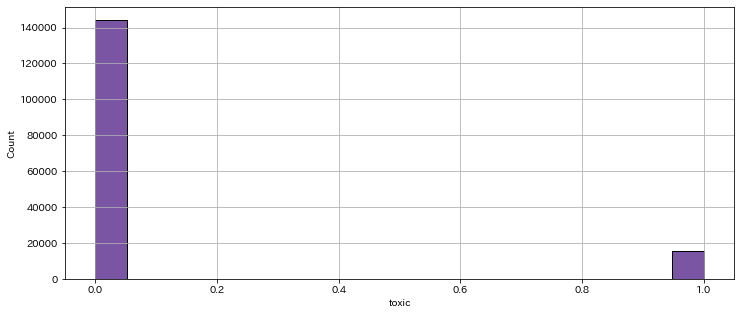

In [30]:
target_cols = [
    "toxic",
    "severe_toxic",
    "obscene",
    "threat",
    "insult",
    "identity_hate"
]

plt.figure(figsize=(12, 5))
sns.histplot(train_df["toxic"], color="#4c1c84")
plt.grid()
plt.show()

In [31]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,is_colon,text,kfold
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,explanation why the edits made under my userna...,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,i aww he matches this background colour i i se...,2
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,hey man i i really not trying to edit war it i...,3
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,more i can i make any real suggestions on impr...,2
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,you sir are my hero any chance you remember wh...,0


<br>
<h1 style = "font-size:45px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    Pytorch Dataset
</h1>
<br>

In [32]:
class JigsawDataset:
    
    def __init__(self, df, tokenizer, max_length, mode, target_cols):
        
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.mode = mode
        self.target_cols = target_cols
        
        if self.mode == "train":
            self.text = df["text"].values
            self.target = df[target_cols].values
            
        elif self.mode == "valid":
            self.more_toxic = df["more_toxic"].values
            self.less_toxic = df["less_toxic"].values
            
        else:
            self.text = df["text"].values
            
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        
        if self.mode == "train":
            
            text = self.text[index]
            target = self.target[index]
            
            inputs_text = self.tokenizer.encode_plus(
                text,
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=True,
                max_length = self.max_len,
                padding="max_length",
            )
            
            text_ids = inputs_text["input_ids"]
            text_mask = inputs_text["attention_mask"]
            text_token_type_ids = inputs_text["token_type_ids"]

            return {
                'text_ids': torch.tensor(text_ids, dtype=torch.long),
                'text_mask': torch.tensor(text_mask, dtype=torch.long),
                'text_token_type_ids': torch.tensor(text_token_type_ids, dtype=torch.long),
                'target': torch.tensor(target, dtype=torch.float)
            }
        
        elif self.mode == "valid":
            
            more_toxic = self.more_toxic[index]
            less_toxic = self.less_toxic[index]

            inputs_more_toxic = self.tokenizer.encode_plus(
                more_toxic,
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=True,
                max_length = self.max_len,
                padding="max_length",
            )

            inputs_less_toxic = self.tokenizer.encode_plus(
                less_toxic,
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=True,
                max_length = self.max_len,
                padding="max_length",
            )
            
            target = 1

            more_toxic_ids = inputs_more_toxic["input_ids"]
            more_toxic_mask = inputs_more_toxic["attention_mask"]
            more_token_type_ids = inputs_more_toxic["token_type_ids"]

            less_toxic_ids = inputs_less_toxic["input_ids"]
            less_toxic_mask = inputs_less_toxic["attention_mask"]
            less_token_type_ids = inputs_less_toxic["token_type_ids"]
            
            return {
                'more_toxic_ids': torch.tensor(more_toxic_ids, dtype=torch.long),
                'more_toxic_mask': torch.tensor(more_toxic_mask, dtype=torch.long),
                'more_token_type_ids': torch.tensor(more_token_type_ids, dtype=torch.long),
                
                'less_toxic_ids': torch.tensor(less_toxic_ids, dtype=torch.long),
                'less_toxic_mask': torch.tensor(less_toxic_mask, dtype=torch.long),
                'less_token_type_ids': torch.tensor(less_token_type_ids, dtype=torch.long),
                
                'target': torch.tensor(target, dtype=torch.float)
            }
        
        else:
            
            text = self.text[index]
            
            inputs_text = self.tokenizer.encode_plus(
                text,
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=True,
                max_length = self.max_len,
                padding="max_length",
            )
            
            text_ids = inputs_text["input_ids"]
            text_mask = inputs_text["attention_mask"]
            text_token_type_ids = inputs_text["token_type_ids"]

            return {
                'text_ids': torch.tensor(text_ids, dtype=torch.long),
                'text_mask': torch.tensor(text_mask, dtype=torch.long),
                'text_token_type_ids': torch.tensor(text_token_type_ids, dtype=torch.long),
            }

<br>
<h2 style = "font-size:45px;
             font-family:Comic Sans MS ;
             font-weight : normal;
             background-color: #eeebf1 ;
             color : #4c1c84;
             text-align: center; 
             border-radius: 100px 100px;">
    DataModule
</h2>
<br>

In [33]:
class JigsawDataModule(LightningDataModule):

    def __init__(self, train_df, valid_df, test_df, cfg):

        super().__init__()
        self._train_df = train_df
        self._valid_df = valid_df
        self._test_df = test_df
        self._cfg = cfg

    def train_dataloader(self):
        dataset = JigsawDataset(
            df=self._train_df, 
            tokenizer=self._cfg.tokenizer,
            max_length=self._cfg.max_length,
            mode="train",
            target_cols=target_cols
            )
        return DataLoader(dataset, **self._cfg.train_loader)

    def val_dataloader(self):
        dataset = JigsawDataset(
            df=self._valid_df, 
            tokenizer=self._cfg.tokenizer,
            max_length=self._cfg.max_length,
            mode="valid",
            target_cols=target_cols
            )
        return DataLoader(dataset, **self._cfg.valid_loader)

    def test_dataloader(self):
        dataset = JigsawDataset(
            df=self._test_df,
            tokenizer = self._cfg.tokenizer,
            max_length=self._cfg.max_length,
            mode="test",
            target_cols=target_cols
        )

        return DataLoader(dataset, **self._cfg.test_loader)

In [34]:
## DataCheck
seed_everything(config.seed)

sample_dataloader = JigsawDataModule(train_df, val_df, test_df, config).train_dataloader()
for data in sample_dataloader:
    break

In [35]:
print(data["text_ids"].size())
print(data["text_mask"].size())
print(data["text_token_type_ids"].size())
print(data["target"].size())
print(data["target"])
output = config.model(
    data["text_ids"],
    data["text_mask"],
    data["text_token_type_ids"],
    output_hidden_states=True,
    output_attentions=True,
)
print(output["hidden_states"][-1].size(), output["attentions"][-1].size())
print(output["hidden_states"][-1][:, 0, :].size(), output["attentions"][-1].size())

torch.Size([8, 256])
torch.Size([8, 256])
torch.Size([8, 256])
torch.Size([8, 6])
tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])
torch.Size([8, 256, 768]) torch.Size([8, 12, 256, 256])
torch.Size([8, 768]) torch.Size([8, 12, 256, 256])


<br>
<h2 style = "font-size:45px;
             font-family:Comic Sans MS ;
             font-weight : normal;
             background-color: #eeebf1 ;
             color : #4c1c84;
             text-align: center; 
             border-radius: 100px 100px;">
    LigitningModule
</h2>
<br>

In [36]:
class JigsawModel(pl.LightningModule):
    
    def __init__(self, cfg, fold_num):
        
        super().__init__()
        self.cfg = cfg
        self.__build_model()
        self.criterion = eval(self.cfg.loss)()
        self.save_hyperparameters(cfg)
        self.fold_num = fold_num
        
    def __build_model(self):
        
        self.base_model = BertForMaskedLM.from_pretrained(
            self.cfg.backbone.name
        )
        print(f"Use Model: {self.cfg.backbone.name}")
        self.norm = nn.LayerNorm(768)
        self.drop = nn.Dropout(p=0.3)
        self.head = nn.Linear(768, self.cfg.backbone.output_dim)
        
    def forward(self, ids, mask, token_type_ids):
        
        output = self.base_model(
            input_ids=ids, 
            attention_mask=mask,
            token_type_ids=token_type_ids,
            output_hidden_states=True,
            output_attentions=True
        )
        feature = self.norm(output["hidden_states"][-1][:, 0, :])
        out = self.drop(feature)
        out = self.head(out)
        
        return {
            "logits":out, 
            "feature":feature,
            "attention":output["attentions"], 
            "mask":mask,
        }
    
    def training_step(self, batch, batch_idx):
        
        text_ids = batch["text_ids"]
        text_mask = batch['text_mask']
        text_token_type_ids = batch['text_token_type_ids']
        targets = batch['target']
        
        outputs = self.forward(text_ids, text_mask, text_token_type_ids)
        loss = torch.sqrt(self.criterion(outputs["logits"], targets))
        
        return {
            "loss":loss,
            "targets":targets,
        }
    
    def training_epoch_end(self, training_step_outputs):

        loss_list = []

        for out in training_step_outputs:

            loss_list.extend([out["loss"].cpu().detach().tolist()])

        meanloss = sum(loss_list)/len(loss_list)

        logs = {f"train_loss/fold{self.fold_num+1}": meanloss,}

        self.log_dict(
            logs,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True
        )
        
    def validation_step(self, batch, batch_idx):

        more_toxic_ids = batch['more_toxic_ids']
        more_toxic_mask = batch['more_toxic_mask']
        more_text_token_type_ids = batch['more_token_type_ids']
        
        less_toxic_ids = batch['less_toxic_ids']
        less_toxic_mask = batch['less_toxic_mask']
        less_text_token_type_ids = batch['less_token_type_ids']
        
        targets = batch['target']

        more_outputs = self.forward(
            more_toxic_ids, 
            more_toxic_mask,
            more_text_token_type_ids
        )
        
        less_outputs = self.forward(
            less_toxic_ids, 
            less_toxic_mask,
            less_text_token_type_ids
        )
        
        
        more_outputs = torch.sum(more_outputs["logits"], 1)
        less_outputs = torch.sum(less_outputs["logits"], 1)
        
        outputs = more_outputs - less_outputs
        logits = outputs.clone()

        logits[logits > 0] = 1
        loss = self.criterion(logits, targets)

        return {
            "loss":loss,
            "pred":outputs,
            "targets":targets,
        }
    
    
    def validation_epoch_end(self, validation_step_outputs):

        loss_list = []
        pred_list = []
        target_list = []

        for out in validation_step_outputs:
            loss_list.extend([out["loss"].cpu().detach().tolist()])
            pred_list.append(out["pred"].detach().cpu().numpy())
            target_list.append(out["targets"].detach().cpu().numpy())

        meanloss = sum(loss_list)/len(loss_list)
        pred_list = np.concatenate(pred_list)
        pred_count = sum(x>0 for x in pred_list)/len(pred_list)

        logs = {
            f"valid_loss/fold{self.fold_num+1}":meanloss,
            f"valid_acc/fold{self.fold_num+1}":pred_count,
        }

        self.log_dict(
            logs,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True
        )
        
    def configure_optimizers(self):

        optimizer = eval(self.cfg.optimizer.name)(
            self.parameters(), **self.cfg.optimizer.params
        )

        self.scheduler = eval(self.cfg.scheduler.name)(
            optimizer, **self.cfg.scheduler.params
        )
        
        scheduler = {"scheduler": self.scheduler, "interval": "step",}

        return [optimizer], [scheduler]

<br>
<h2 style = "font-size:45px;
             font-family:Comic Sans MS ;
             font-weight : normal;
             background-color: #eeebf1 ;
             color : #4c1c84;
             text-align: center; 
             border-radius: 100px 100px;">
    Training
</h2>
<br>

In [37]:
skf = KFold(
    n_splits=config.n_fold, 
    shuffle=True, 
    random_state=config.seed
)

for fold, (_, val_idx) in enumerate(skf.split(X=train_df, y=train_df["toxic"])):
    train_df.loc[val_idx, "kfold"] = int(fold)

train_df["kfold"] = train_df["kfold"].astype(int)
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,is_colon,text,kfold
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,explanation why the edits made under my userna...,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,i aww he matches this background colour i i se...,2
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,hey man i i really not trying to edit war it i...,3
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,more i can i make any real suggestions on impr...,2
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,you sir are my hero any chance you remember wh...,0


In [78]:
## Debug
config.trainer.fast_dev_run = True
config.backbone.output_dim = len(target_cols)

for fold in config.train_fold:
    
    print("★"*25, f" Fold{fold+1} ", "★"*25)

    df_train = train_df[train_df.kfold != fold].reset_index(drop=True)

    datamodule = JigsawDataModule(df_train, val_df, test_df, config)
    sample_dataloader = JigsawDataModule(df_train, val_df, test_df, config).train_dataloader()

    config.scheduler.params.T_0 = config.epoch * len(sample_dataloader)
    model = JigsawModel(config, fold)
    lr_monitor = callbacks.LearningRateMonitor()

    loss_checkpoint = callbacks.ModelCheckpoint(
        filename=f"best_acc_fold{fold+1}",
        monitor=f"valid_acc/fold{fold+1}",
        save_top_k=1,
        mode="max",
        save_last=False,
        dirpath=MODEL_DIR,
        save_weights_only=True,
    )

    wandb_logger = WandbLogger(
        project=config.project, 
        entity=config.entity,
        name = f"{config.exp_name}",
        tags = ['Hate-BERT', "Jigsaw-Classification"]
    )

    lr_monitor = LearningRateMonitor(logging_interval='step')

    trainer = pl.Trainer(
        max_epochs=config.epoch,
        callbacks=[loss_checkpoint, lr_monitor, RichProgressBar()],
#         deterministic=True,
        logger=[wandb_logger],
        **config.trainer
    )
    trainer.fit(model, datamodule=datamodule)

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold1  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: GroNLP/hateBERT


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type            ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model │ BertForMaskedLM │  109 M │
│ 1 │ norm       │ LayerNorm       │  1.5 K │
│ 2 │ drop       │ Dropout         │      0 │
│ 3 │ head       │ Linear          │  4.6 K │
│ 4 │ criterion  │ MSELoss         │      0 │
└───┴────────────┴─────────────────┴────────┘

Trainable params: 109 M                                                                      
Non-trainable params: 0                                                                      
Total params: 109 M                                                                          
Total estimated model params size (MB): 438

Output()

Epoch 0    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 0:00:00 • 0:00:00 3.73it/s loss: 0.591 v_num:  

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold2  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: GroNLP/hateBERT


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type            ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model │ BertForMaskedLM │  109 M │
│ 1 │ norm       │ LayerNorm       │  1.5 K │
│ 2 │ drop       │ Dropout         │      0 │
│ 3 │ head       │ Linear          │  4.6 K │
│ 4 │ criterion  │ MSELoss         │      0 │
└───┴────────────┴─────────────────┴────────┘

Trainable params: 109 M                                                                      
Non-trainable params: 0                                                                      
Total params: 109 M                                                                          
Total estimated model params size (MB): 438

Output()

Epoch 0    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 0:00:00 • 0:00:00 3.67it/s loss: 0.641 v_num:  

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold3  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: GroNLP/hateBERT


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type            ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model │ BertForMaskedLM │  109 M │
│ 1 │ norm       │ LayerNorm       │  1.5 K │
│ 2 │ drop       │ Dropout         │      0 │
│ 3 │ head       │ Linear          │  4.6 K │
│ 4 │ criterion  │ MSELoss         │      0 │
└───┴────────────┴─────────────────┴────────┘

Trainable params: 109 M                                                                      
Non-trainable params: 0                                                                      
Total params: 109 M                                                                          
Total estimated model params size (MB): 438

Output()

Epoch 0    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 0:00:00 • 0:00:00 3.44it/s loss: 0.675 v_num:  

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold4  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: GroNLP/hateBERT


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type            ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model │ BertForMaskedLM │  109 M │
│ 1 │ norm       │ LayerNorm       │  1.5 K │
│ 2 │ drop       │ Dropout         │      0 │
│ 3 │ head       │ Linear          │  4.6 K │
│ 4 │ criterion  │ MSELoss         │      0 │
└───┴────────────┴─────────────────┴────────┘

Trainable params: 109 M                                                                      
Non-trainable params: 0                                                                      
Total params: 109 M                                                                          
Total estimated model params size (MB): 438

Output()

Epoch 0    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 0:00:00 • 0:00:00 3.10it/s loss: 0.581 v_num:  

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold5  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: GroNLP/hateBERT


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type            ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model │ BertForMaskedLM │  109 M │
│ 1 │ norm       │ LayerNorm       │  1.5 K │
│ 2 │ drop       │ Dropout         │      0 │
│ 3 │ head       │ Linear          │  4.6 K │
│ 4 │ criterion  │ MSELoss         │      0 │
└───┴────────────┴─────────────────┴────────┘

Trainable params: 109 M                                                                      
Non-trainable params: 0                                                                      
Total params: 109 M                                                                          
Total estimated model params size (MB): 438

Output()

Epoch 0    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 0:00:00 • 0:00:00 2.85it/s loss: 0.769 v_num:  

In [ ]:
## Training
config.trainer.fast_dev_run = False
config.backbone.output_dim = len(target_cols)

for fold in config.train_fold:
    
    print("★"*25, f" Fold{fold+1} ", "★"*25)

    df_train = train_df[train_df.kfold != fold].reset_index(drop=True)

    datamodule = JigsawDataModule(df_train, val_df, test_df, config)
    sample_dataloader = JigsawDataModule(df_train, val_df, test_df, config).train_dataloader()

    config.scheduler.params.T_0 = config.epoch * len(sample_dataloader)
    model = JigsawModel(config, fold)
    lr_monitor = callbacks.LearningRateMonitor()

    loss_checkpoint = callbacks.ModelCheckpoint(
        filename=f"best_acc_fold{fold+1}",
        monitor=f"valid_acc/fold{fold+1}",
        save_top_k=1,
        mode="max",
        save_last=False,
        dirpath=MODEL_DIR,
        save_weights_only=True,
    )

    wandb_logger = WandbLogger(
        project=config.project, 
        entity=config.entity,
        name = f"{config.exp_name}",
        tags = ['Hate-BERT', "Jigsaw-Classification"]
    )

    lr_monitor = LearningRateMonitor(logging_interval='step')

    trainer = pl.Trainer(
        max_epochs=config.epoch,
        callbacks=[loss_checkpoint, lr_monitor, RichProgressBar()],
#         deterministic=True,
        logger=[wandb_logger],
        **config.trainer
    )
    trainer.fit(model, datamodule=datamodule)

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold1  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: GroNLP/hateBERT


wandb: Currently logged in as: dataskywalker (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2022-01-27 09:12:16.260800: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
fatal: ambiguous argument 'HEAD': unknown revision or path not in the working tree.
Use '--' to separate paths from revisions, like this:
'git <command> [<revision>...] -- [<file>...]'

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type            ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model │ BertForMaskedLM │  109 M │
│ 1 │ norm       │ LayerNorm       │  1.5 K │
│ 2 │ drop       │ Dropout         │      0 │
│ 3 │ head       │ Linear          │  4.6 K │
│ 4 │ criterion  │ MSELoss         │      0 │
└───┴────────────┴─────────────────┴────────┘

Trainable params: 109 M                                                                      
Non-trainable params: 0                                                                      
Total params: 109 M                                                                          
Total estimated model params size (MB): 438

Output()

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config.backbone.output_dim = len(target_cols)

print(f"Device == {device}")

MORE = np.zeros((len(val_df), config.backbone.output_dim))
LESS = np.zeros((len(val_df), config.backbone.output_dim))
PRED = np.zeros((len(test_df), config.backbone.output_dim))

attention_array = np.zeros((len(val_df), 256)) # attention格納
mask_array = np.zeros((len(val_df), 256)) # mask情報格納,後でattentionと掛け合わせる

for fold in config.train_fold:

    pred_list = []
    print("★"*25, f" Fold{fold+1} ", "★"*25)

    valid_dataloader = JigsawDataModule(train_df, val_df, test_df, config).val_dataloader()
    model = JigsawModel(config, fold)

    loss_checkpoint = callbacks.ModelCheckpoint(
        filename=f"best_acc_fold{fold+1}",
        monitor=f"valid_acc/fold{fold+1}",
        save_top_k=1,
        mode="max",
        save_last=False,
        dirpath="../input/toxicroberta/",
    )
    model = model.load_from_checkpoint(MODEL_DIR/f"best_acc_fold{fold+1}-v1.ckpt", cfg=config, fold_num=fold)
    model.to(device)
    model.eval()
    
    more_list = []
    less_list = []
    
    for step, data in tqdm(enumerate(valid_dataloader), total=len(valid_dataloader)):

        more_toxic_ids = data['more_toxic_ids'].to(device)
        more_toxic_mask = data['more_toxic_mask'].to(device)
        more_text_token_type_ids = data['more_token_type_ids'].to(device)
        
        less_toxic_ids = data['less_toxic_ids'].to(device)
        less_toxic_mask = data['less_toxic_mask'].to(device)
        less_text_token_type_ids = data['less_token_type_ids'].to(device)
        
        more_outputs = model(
            more_toxic_ids, 
            more_toxic_mask,
            more_text_token_type_ids,
        )
        
        less_outputs = model(
            less_toxic_ids, 
            less_toxic_mask,
            less_text_token_type_ids
        )
        
        more_list.append(more_outputs["logits"].detach().cpu().numpy())
        less_list.append(less_outputs["logits"].detach().cpu().numpy())

    MORE += np.concatenate(more_list)/len(config.train_fold)
    LESS += np.concatenate(less_list)/len(config.train_fold)
#     PRED += pred_list/len(config.train_fold)

Device == cuda
★★★★★★★★★★★★★★★★★★★★★★★★★  Fold1  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: GroNLP/hateBERT
Use Model: GroNLP/hateBERT


  0%|          | 0/3764 [00:00<?, ?it/s]

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold2  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: GroNLP/hateBERT
Use Model: GroNLP/hateBERT


  0%|          | 0/3764 [00:00<?, ?it/s]

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold3  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: GroNLP/hateBERT
Use Model: GroNLP/hateBERT


  0%|          | 0/3764 [00:00<?, ?it/s]

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold4  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: GroNLP/hateBERT
Use Model: GroNLP/hateBERT


  0%|          | 0/3764 [00:00<?, ?it/s]

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold5  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: GroNLP/hateBERT
Use Model: GroNLP/hateBERT


  0%|          | 0/3764 [00:00<?, ?it/s]

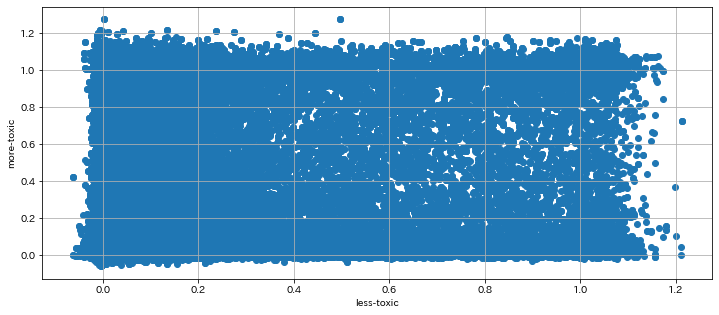

In [40]:
plt.figure(figsize=(12, 5))
plt.scatter(LESS, MORE)
plt.xlabel("less-toxic")
plt.ylabel("more-toxic")
plt.grid()
plt.show()

In [41]:
val_df["less_attack"] = LESS.sum(axis=1)
val_df["more_attack"] = MORE.sum(axis=1)
val_df["diff_attack"] = val_df["more_attack"] - val_df["less_attack"]
attack_score = val_df[val_df["diff_attack"]>0]["diff_attack"].count()/len(val_df)
print(f"exp033 Score: {attack_score:.6f}")

exp033 Score: 0.687160


<br>
<h2 style = "font-size:45px;
             font-family:Comic Sans MS ;
             font-weight : normal;
             background-color: #eeebf1 ;
             color : #4c1c84;
             text-align: center; 
             border-radius: 100px 100px;">
    Attention Visualize
</h2>
<br>

In [42]:
text_df = pd.DataFrame()
text_df["text"] = list(set(val_df["less_toxic"].unique().tolist() + val_df["more_toxic"].unique().tolist()))

display(text_df.head())
display(text_df.shape)

,text
0,xman52 i talking rubbish again when calzaghe f...
1,is congratulations on receiving the bitch star...
2,hi dipshit just so we re clear i i into vandal...
3,sweetie darlings you will never outrun me i ha...
4,either way you should unprotect the article an...


(14317, 1)

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config.backbone.output_dim = len(target_cols)

print(f"Device == {device}")

attention_array = np.zeros((len(text_df), config.max_length)) # attention格納
mask_array = np.zeros((len(text_df), config.max_length)) # mask情報格納,後でattentionと掛け合わせる
feature_array = np.zeros((len(text_df), 768))
PRED = np.zeros((len(text_df), config.backbone.output_dim))

for fold in config.train_fold:

    pred_list = []
    print("★"*25, f" Fold{fold+1} ", "★"*25)

    test_dataloader = JigsawDataModule(train_df, val_df, text_df, config).test_dataloader()
    model = JigsawModel(config, fold)

    loss_checkpoint = callbacks.ModelCheckpoint(
        filename=f"best_acc_fold{fold+1}",
        monitor=f"valid_acc/fold{fold+1}",
        save_top_k=1,
        mode="max",
        save_last=False,
        dirpath="../input/toxicroberta/",
    )
    model = model.load_from_checkpoint(MODEL_DIR/f"best_acc_fold{fold+1}-v1.ckpt", cfg=config, fold_num=fold)
    model.to(device)
    model.eval()
    
    attention_list = []
    feature_list = []
    mask_list = []
    pred_list = []
    
    for step, data in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):

        text_ids = data["text_ids"].to(device)
        text_mask = data["text_mask"].to(device)
        text_token_type_ids = data["text_token_type_ids"].to(device)
        
        mask_list.append(text_mask.detach().cpu().numpy())
            
        outputs = model(
            text_ids, 
            text_mask,
            text_token_type_ids,
        )
        
        ## Last LayerのCLS Tokenに対するAttention
        last_attention = outputs["attention"][-1].detach().cpu().numpy()
        total_attention = np.zeros((last_attention.shape[0], config.max_length))
        
        for batch in range(last_attention.shape[0]):
            for n_head in range(12):
                total_attention[batch, :] += last_attention[batch, n_head, 0, :]
                
        attention_list.append(total_attention)
        pred_list.append(outputs["logits"].detach().cpu().numpy())
        feature_list.append(outputs["feature"].detach().cpu().numpy())

    attention_array += np.concatenate(attention_list)/config.n_fold
    mask_array += np.concatenate(mask_list)/config.n_fold
    feature_array += np.concatenate(feature_list)/config.n_fold
    PRED += np.concatenate(pred_list)/len(config.train_fold)
    
    

Device == cuda
★★★★★★★★★★★★★★★★★★★★★★★★★  Fold1  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: GroNLP/hateBERT
Use Model: GroNLP/hateBERT


  0%|          | 0/1790 [00:00<?, ?it/s]

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold2  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: GroNLP/hateBERT
Use Model: GroNLP/hateBERT


  0%|          | 0/1790 [00:00<?, ?it/s]

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold3  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: GroNLP/hateBERT
Use Model: GroNLP/hateBERT


  0%|          | 0/1790 [00:00<?, ?it/s]

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold4  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: GroNLP/hateBERT
Use Model: GroNLP/hateBERT


  0%|          | 0/1790 [00:00<?, ?it/s]

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold5  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: GroNLP/hateBERT
Use Model: GroNLP/hateBERT


  0%|          | 0/1790 [00:00<?, ?it/s]

In [45]:
text_df["target"] = PRED[:, 0]
text_df.to_pickle(OUTPUT_DIR/"text_df.pkl")
np.save(OUTPUT_DIR/'toxic-bert-exp033-attention.npy', attention_array)
np.save(OUTPUT_DIR/'toxic-bert-exp033-mask.npy', mask_array)
np.save(OUTPUT_DIR/'toxic-bert-exp033-feature.npy', feature_array)

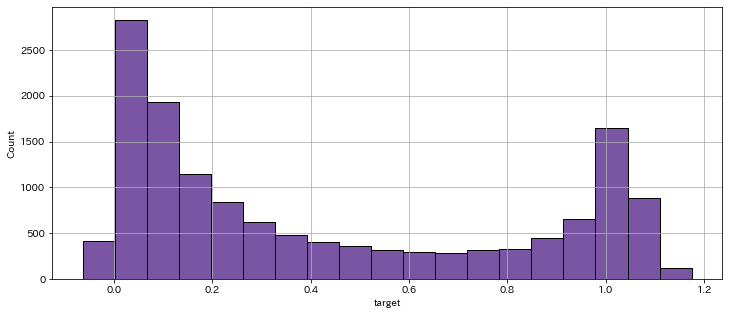

In [46]:
plt.figure(figsize=(12, 5))
sns.histplot(text_df["target"], color="#4c1c84")
plt.grid()
plt.show()

<br>
<h2 style = "font-size:45px;
             font-family:Comic Sans MS ;
             font-weight : normal;
             background-color: #eeebf1 ;
             color : #4c1c84;
             text-align: center; 
             border-radius: 100px 100px;">
    Attention Load
</h2>
<br>

In [47]:
text_df = pd.read_pickle(OUTPUT_DIR/"text_df.pkl")
attention_array = np.load(OUTPUT_DIR/'toxic-bert-exp033-attention.npy')
mask_array = np.load(OUTPUT_DIR/'toxic-bert-exp033-mask.npy')
feature_array = np.load(OUTPUT_DIR/'toxic-bert-exp033-feature.npy')

In [48]:
from IPython.display import display, HTML

def highlight_r(word, attn):
    html_color = '#%02X%02X%02X' % (255, int(255*(1 - attn)), int(255*(1 - attn)))
    return '<span style="background-color: {}">{}</span>'.format(html_color, word)

In [49]:
num = 12

ids = config.tokenizer(text_df.loc[num, "text"])["input_ids"]
tokens = config.tokenizer.convert_ids_to_tokens(ids)
attention = attention_array[num, :][np.nonzero(mask_array[num, :])]

html_outputs = []

for word, attn in zip(tokens, attention):
    html_outputs.append(highlight_r(word, attn))

print(f"Offensive Score is {PRED[num, 0]}")
display(HTML(' '.join(html_outputs)))
display(text_df.loc[num, "text"])

Offensive Score is 0.9471661150455475


'not me doing the shocker bitch'

In [50]:
text_df.sort_values("target", ascending=False).head(20)

,text,target
4942,congratulations on being such a huge fucking a...,1.174115
13726,you can also go out and suck 500 dicks and suc...,1.174111
8017,dumbledore suck my balls i suck my balls,1.174053
243,you suck deadly assassin is gay,1.170887
13350,penis pennis penis pensnsnniensnsn penis penis...,1.168586
7062,epbr123 is a bigger faggot then wikipedia and ...,1.164875
3228,i am a really big fat fag i like to jerkoff in...,1.163759
11468,i love dicks in my butt user,1.162294
5796,go fuck yourselfto fuck yourselfto fuck yourse...,1.159175
6948,hi im so gay and retarded we suck so many ball...,1.159142


In [51]:
high_score_list = text_df.sort_values("target", ascending=False).head(20).index.tolist()

for num in high_score_list:
    
    ids = config.tokenizer(text_df.loc[num, "text"])["input_ids"]
    tokens = config.tokenizer.convert_ids_to_tokens(ids)
    attention = attention_array[num, :][np.nonzero(mask_array[num, :])]

    html_outputs = []

    for word, attn in zip(tokens, attention):
        html_outputs.append(highlight_r(word, attn))

    print(f"Offensive Score is {PRED[num, 0]}")
    display(HTML(' '.join(html_outputs)))
    display(text_df.loc[num, "text"])



Token indices sequence length is longer than the specified maximum sequence length for this model (1194 > 512). Running this sequence through the model will result in indexing errors


Offensive Score is 1.1741149425506592


'congratulations on being such a huge fucking asshole bongwarriorcongratualtions on being such a huge fucking asshole bongwarriorcongratualtions on being such a huge fucking asshole bongwarriorcongratualtions on being such a huge fucking asshole bongwarriorcongratualtions on being such a huge fucking asshole bongwarriorcongratualtions on being such a huge fucking asshole bongwarriorcongratualtions on being such a huge fucking asshole bongwarriorcongratualtions on being such a huge fucking asshole bongwarriorcongratualtions on being such a huge fucking asshole bongwarriorcongratualtions on being such a huge fucking asshole bongwarriorcongratualtions on being such a huge fucking asshole bongwarriorcongratualtions on being such a huge fucking asshole bongwarriorcongratualtions on being such a huge fucking asshole bongwarriorcongratualtions on being such a huge fucking asshole bongwarriorcongratualtions on being such a huge fucking asshole bongwarriorcongratualtions on being such a huge fu

Offensive Score is 1.1741114407777786


'you can also go out and suck 500 dicks and suck your daddy i dick too amen'

Offensive Score is 1.1740529835224152


'dumbledore suck my balls i suck my balls'

Offensive Score is 1.1708874702453613


'you suck deadly assassin is gay'

Offensive Score is 1.1685859560966492


'penis pennis penis pensnsnniensnsn penis penis pennis penis pensnsnniensnsn penis penis pennis penis pensnsnniensnsn penis penis pennis penis pensnsnniensnsn penis penis pennis penis pensnsnniensnsn penis penis pennis penis pensnsnniensnsn penis penis pennis penis pensnsnniensnsn penis penis pennis penis pensnsnniensnsn penis penis pennis penis pensnsnniensnsn penis penis pennis penis pensnsnniensnsn penis penis pennis penis pensnsnniensnsn penis penis pennis penis pensnsnniensnsn penis penis pennis penis pensnsnniensnsn penis penis pennis penis pensnsnniensnsn penis penis pennis penis pensnsnniensnsn penis penis pennis penis pensnsnniensnsn penis penis pennis penis pensnsnniensnsn penis penis pennis penis pensnsnniensnsn penis penis pennis penis pensnsnniensnsn penis penis pennis penis pensnsnniensnsn penis penis pennis penis pensnsnniensnsn penis penis pennis penis pensnsnniensnsn penis penis pennis penis pensnsnniensnsn penis penis pennis penis pensnsnniensnsn penis penis pennis pe

Offensive Score is 1.1648753732442856


'epbr123 is a bigger faggot then wikipedia and loves to suck the cock epbr123 is a bigger faggot then wikipedia and loves to suck the cock epbr123 is a bigger faggot then wikipedia and loves to suck the cock epbr123 is a bigger faggot then wikipedia and loves to suck the cock epbr123 is a bigger faggot then wikipedia and loves to suck the cock epbr123 is a bigger faggot then wikipedia and loves to suck the cock epbr123 is a bigger faggot then wikipedia and loves to suck the cock epbr123 is a bigger faggot then wikipedia and loves to suck the cock epbr123 is a bigger faggot then wikipedia and loves to suck the cock'

Offensive Score is 1.163759022951126


'i am a really big fat fag i like to jerkoff in my free time'

Offensive Score is 1.1622943580150604


'i love dicks in my butt user'

Offensive Score is 1.1591747552156448


'go fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck yourselfto fuck

Offensive Score is 1.1591417491436005


'hi im so gay and retarded we suck so many balls oo i love men'

Offensive Score is 1.1568662822246552


'i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cu

Offensive Score is 1.1568662822246552


'i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cuntbag i am a cu

Offensive Score is 1.1548528373241425


'you suck it big time you suck it big time'

Offensive Score is 1.154758632183075


'how big is ur cock i wanna suck u dry'

Offensive Score is 1.1536963880062103


'i i wanna fuck a dog in the ass'

Offensive Score is 1.1506949067115784


'matt bakers dad sucked my big fat cock last night'

Offensive Score is 1.1488575637340546


'people on this site suck people on this site suck'

Offensive Score is 1.1485898792743683


'wesley bart likes to suck cock loves that cock he can i live without the cock'

Offensive Score is 1.148016333580017


'everybody lock ur dicks cuz theyre gay'

Offensive Score is 1.1476316899061203


'i fucked your mom last night it felt awsome i stuck my dick in her mouth and in her pussy she let me lick her tits and fuck her all night long yee haa is what i was screaming'